<h4>Context</h4>
This is an investigation of reading habits using the <i>Reading habit Dataset</i>, available <a href="https://www.kaggle.com/datasets/vipulgote4/reading-habit-dataset/data">here</a>. This notebook walks through an assessment of the dataset and its quality, before processing and tidying the data. It then looks at an exploratory data analysis of the data. After investigating the interconnections between the variables, some machine learning models are trialled to see which would be an appropriate fit for the data. The best performing model is then selected. Following this, insights and recommendations are discussed.

<h4>Strategy employed:</h4>
<li>Look at data and assess quality, and come up with a strategy for tidying data</li>
<li>Write a pipeline that pulls in the data and serves it for EDA</li>
<li>Begin EDA, focusing on interactions, with univariate and multivariate analyses</li>
<li>Feed data into several models, evaluate each and choose best</li>
<li>Optimise the best performing model, then prime it for making predictions on new data</li>

In [47]:
# standard packages for handling and exploring data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# packages for performing predictive analytics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# packages for data cleaning and processing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prefect import flow, task

<h2>Dataset assessment</h2>
The dataset used here is the <i>Reading habit Dataset</i>, available <a href="https://www.kaggle.com/datasets/vipulgote4/reading-habit-dataset/data">here</a>. The description of the dataset is a little light, and the provenance is unclear. The user seems to have gotten it from Pew Research Center, probably from <a href="https://www.pewresearch.org/dataset/december-2011-reading-habits/">here</a>. It has a similar name and the description seems to cover the contents. However, I was unable to download the original dataset to confirm. This dataset is a survey from 2011, which already means that we should be skeptical about what insights we can generate from this data--for example, ebook usage has change dramatically since, with the <a href="https://www.statista.com/outlook/dmo/digital-media/epublishing/ebooks/worldwide">market for digital books growing significantly</a> in the past decade. However, this dataset does provide us with a snapshot in time that we can build on. In the recommendations below, I suggest conducting a follow up study to compare the differences between past reading habits and current reading habits. This dataset therefore has historical value.

In [48]:
### first step: import data and look at it

data = pd.read_csv('reading.csv')
data.head()

,Age,Sex,Race,Marital status?,Education,Employement,Incomes,How many books did you read during last 12months?,Read any printed books during last 12months?,Read any audiobooks during last 12months?,Read any e-books during last 12months?,"Last book you read, you…",Do you happen to read any daily news or newspapers?,Do you happen to read any magazines or journals?
0,66,Male,Refused,Divorced,College graduate,Retired,"$20,000 to under $30,000",97,Yes,No,Yes,Purchased the book,No,Yes
1,46,Male,Native American/American Indian,Married,High school graduate,Employed full-time,"Less than $10,000",97,Yes,Yes,Yes,Purchased the book,Yes,Yes
2,32,Male,Mixed race,Never been married,High school graduate,Employed full-time,"Less than $10,000",97,No,Yes,Yes,Borrowed the book from a friend or family member,Yes,Yes
3,27,Male,Mixed race,Married,High school graduate,Employed full-time,"$40,000 to under $50,000",97,Yes,No,Yes,Borrowed the book from a library,Yes,No
4,16,Female,Mixed race,Never been married,High school incomplete,Employed part-time,"$10,000 to under $20,000",97,Yes,Yes,No,Purchased the book,Yes,No


First impressions: Column headings look really long, as do some of the response. I would like to shorten these as I tidy this up. Otherwise, there is nothing majorly concerning about the structure and formatting so far.

We are missing some key information, in particular location. Where are the users based? I would assume, given the '$' in the income response and the specification of Native American, that this is a study on the United States. But which states? Is the sample representative of the country as a whole? How far can we generalise our findings? This is a concern, and limits how far we can take this analysis.

There is also no ID column, which is concerning. How do we know that the same user hasn't taken the survey twice, for example? There may be duplicate responses that we cannot identify and remove because of this lack of identifying information. 

In [49]:
### look at meta information about the columns

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 14 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Age                                                  2832 non-null   int64 
 1   Sex                                                  2832 non-null   object
 2   Race                                                 2832 non-null   object
 3   Marital status?                                      2832 non-null   object
 4   Education                                            2832 non-null   object
 5   Employement                                          2832 non-null   object
 6   Incomes                                              2832 non-null   object
 7   How many books did you read during last 12months?    2832 non-null   int64 
 8   Read any printed books during last 12months?         2442 non-null   object
 9

In [50]:
### check for nulls

data.isna().sum()

Age                                                      0
Sex                                                      0
Race                                                     0
Marital status?                                          0
Education                                                0
Employement                                              0
Incomes                                                  0
How many books did you read during last 12months?        0
Read any printed books during last 12months?           390
Read any audiobooks during last 12months?              390
Read any e-books during last 12months?                 390
Last book you read, you…                               390
Do you happen to read any daily news or newspapers?      0
Do you happen to read any magazines or journals?         0
dtype: int64

In [51]:
total_rows = len(data)
shortest_col = data.count().min()

perc_loss = (total_rows - shortest_col) / total_rows * 100

print(f"Removing the non-null rows would mean a {round(perc_loss,1)}% in the dataset")

Removing the non-null rows would mean a 13.8% in the dataset


The responses look mostly complete, which is good; however, we have four columns that have fewer responses than the others. It is not immediately clear at this stage why this is. A decision will have to be made later about whether to either remove rows that don't include responses to these questions, or remove these questions from the analysis. As these look like important questions, I would lean to the former. However, this would mean we'd lose 13.8% of the data. But I have a suspicion as to why this might be...

Let's try removing the null values and see what this does:

In [60]:
data_noNull = data.copy()
data_noNull.dropna(inplace=True)

print(f"Minimum number of books read in original data: {data['How many books did you read during last 12months?'].min()}")
print(f"Minimum number of books read in data after nulls dropped: {data_noNull['How many books did you read during last 12months?'].min()}")

Minimum number of books read in original data: 0
Minimum number of books read in data after nulls dropped: 1


As suspected: <b>These questions were only presented to people who have read books!</b>

So, for our cleaning strategy, let's assign all null responses as '0'.

In [58]:
### check for duplicates

data[data.duplicated()]

,Age,Sex,Race,Marital status?,Education,Employement,Incomes,How many books did you read during last 12months?,Read any printed books during last 12months?,Read any audiobooks during last 12months?,Read any e-books during last 12months?,"Last book you read, you…",Do you happen to read any daily news or newspapers?,Do you happen to read any magazines or journals?
1023,65,Male,White,Married,College graduate,Retired,"$75,000 to under $100,000",12,Yes,No,Yes,Purchased the book,Yes,Yes


It looks like there is one 'duplicated' row. However, without the ID column we cannot know if this is a true duplicate. In a survey of 2832 people, the chances of two people entering the same information are reasonably high; so, I don't have enough reason to consider this a true duplicate and remove it.

In [59]:
### run some descriptive statistics of the numerical columns

data.describe()

,Age,How many books did you read during last 12months?
count,2832.000000,2832.000000
mean,47.276483,16.676201
std,18.565516,23.632071
min,16.000000,0.000000
25%,32.000000,2.750000
50%,48.000000,6.000000
75%,62.000000,20.000000
max,93.000000,97.000000


There doesn't seem to be anything untoward here--the oldest respondent was 93, and the youngest 16, which is within reasonable bounds. The most books read in the past 12 months is 97, which is a lot of books! I would be interested to know more about the people reading that many.

Time to look at some graphics of the data to see distributions and shape of the data.

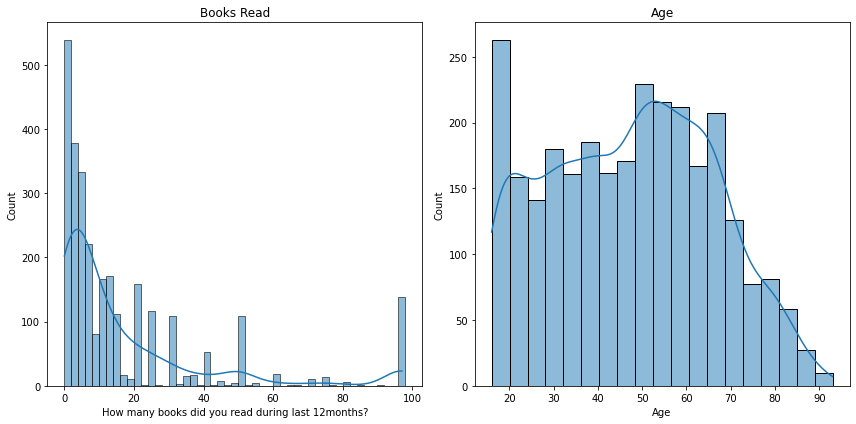

In [61]:
### look at graphs numerical variables

# lets look at two plots of books read and age side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data['How many books did you read during last 12months?'], kde=True, ax=axes[0], binwidth=2)
axes[0].set_title('Books Read')

sns.histplot(data['Age'], kde=True, ax=axes[1])
axes[1].set_title('Age')

plt.tight_layout()
plt.show()

<h4>Books read</h4>
<p>Looks interesting, and mostly what I'd expect--there are some spikes around certain numbers (20, 30, 40, 50) that show people are estimating. It does mean we should take responses with a pinch of salt, as we cannot completely trust their recall. Without actually keeping track, can people really remember how many books they've read over a 12 month period? There are also a lot of non-readers; it will be interesting to see if anything differentiates these people.</p>

<p>There is also a strange spike at the end. We know that the highest number is 97, and a lot of people have responded with this number. Why? I might speculate that, for whatever reason, responses may have been capped at this number, so there are people who potentially may have read more who could only enter as high as 97. This, along with the recall issues described above, will affect the accuracy of any predictions.</p>

<h4>Age</h4>
The distribution is <i>almost</i> what I would expect--it looks like the centre of a normal distribution. However, there are a lot of 16 year olds. Again, this might be some quirk of the data validation, with people younger than 16 taking the survey, but with a lower cutoff of 16. Or, the survey was sent around a school; alas, as we don't know the collection method, we cannot say for sure. As I am interested in the adult book market, however, I will remove anyone under the age of 18.

In [62]:
data[data['Age'] < 18].count()

Age                                                    136
Sex                                                    136
Race                                                   136
Marital status?                                        136
Education                                              136
Employement                                            136
Incomes                                                136
How many books did you read during last 12months?      136
Read any printed books during last 12months?           129
Read any audiobooks during last 12months?              129
Read any e-books during last 12months?                 129
Last book you read, you…                               129
Do you happen to read any daily news or newspapers?    136
Do you happen to read any magazines or journals?       136
dtype: int64

In [64]:
print(f"If we get rid of under 18s, we'd lose around {round(data[data['Age'] < 18].count().max() / data.count().max()  * 100, 1)}% of the dataset")

If we get rid of under 18s, we'd lose around 4.8% of the dataset


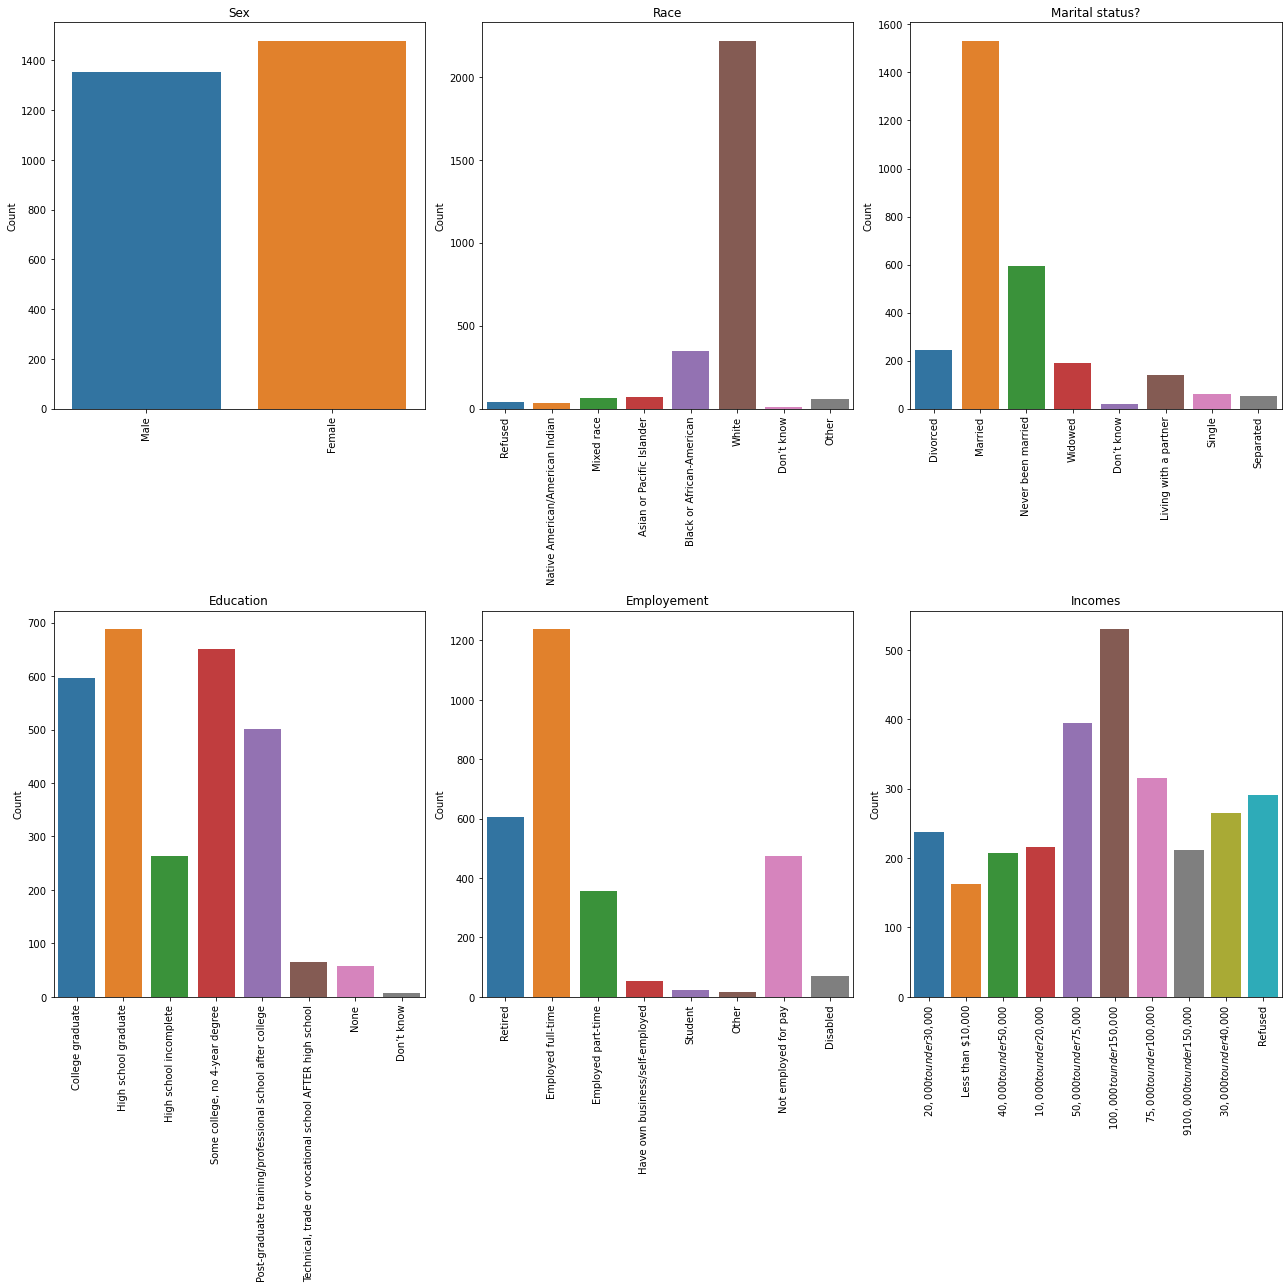

In [65]:
### lets have a look at the categorical variables

cols = list(data.columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(cols[1:7]):
    sns.countplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('Count')  # Set y-axis label
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    
plt.tight_layout()
plt.show()

Some key things to note: There are a few answers for 'Refused' and 'Don't Know' across the questions, in particular income. As income is a key predictor--and as books read could be a predictor of income--this is an important ommission. There looks like a disproportionate number of married respondents, but a good spread of education and income ranges. The income spreads are probably more even than implied by the graph, given how the incomes have been binned. It would have been good to have the actual numbers, and then we could bin them ourselves. For example, to USD 50,000, there are 5 bins, and thereafter there are only 3 up to USD 150,000. (Also, note the spelling error for one of the bins: '<b><i>9</i></b>100,000 to under 150,000'.) There is also no option for those higher than USD 150,000, which is curious; given that there is a disproportionate number of high earners in that upper bracket, it may be the case that people earning over USD 150,000 are selecting that option. Again, all things to bear in mind as we consider the accuracy of any predictions made using this dataset.

Otherwise, there are some interesting demographic findings here; the ratio of sex looks slightly imbalanced, as does the racial make up of the sample. Let's have a closer look at the numbers here.

In [66]:
category_counts = data['Sex'].value_counts()
category_percentages = category_counts / len(data) * 100
print('Sex')
print(category_percentages)
print('\nRace')
category_counts = data['Race'].value_counts()
category_percentages = category_counts / len(data) * 100
print(category_percentages)
print('\nIncome')
category_counts = data['Incomes'].value_counts()
category_percentages = category_counts / len(data) * 100
print(category_percentages)

Sex
Female    52.224576
Male      47.775424
Name: Sex, dtype: float64

Race
White                              78.283898
Black or African-American          12.252825
Asian or Pacific Islander           2.471751
Mixed race                          2.224576
Other                               2.048023
Refused                             1.306497
Native American/American Indian     1.094633
Don’t know                          0.317797
Name: Race, dtype: float64

Income
$100,000 to under $150,000     18.714689
$50,000 to under $75,000       13.912429
$75,000 to under $100,000      11.158192
Refused                        10.275424
$30,000 to under $40,000        9.357345
$20,000 to under $30,000        8.403955
$10,000 to under $20,000        7.627119
9$100,000 to under $150,000     7.485876
$40,000 to under $50,000        7.309322
Less than $10,000               5.755650
Name: Incomes, dtype: float64


Women look to be slightly over-represented compared to the population generally. 10.3% of people refused to declare their income. I'd lean towards removing these from the sample--are people who refused too private, or perhaps disproportionately low earners? Or perhaps they're high earners who wouldn't want people to know? Or a mixture of both?

The racial make up looks fairly accurate, if we consider Hispanics under White, which it looks like this survey has. (See <a href="https://usafacts.org/data/topics/people-society/population-and-demographics/our-changing-population/?endDate=2022-01-01&startDate=2011-01-01"> here</a>.) Black and Asian people might be slightly under-represented, particularly Asians by a couple of percentage points.

Either way, without knowing where these people were sampled from, we should be careful extrapolating any findings to the United States as a whole.

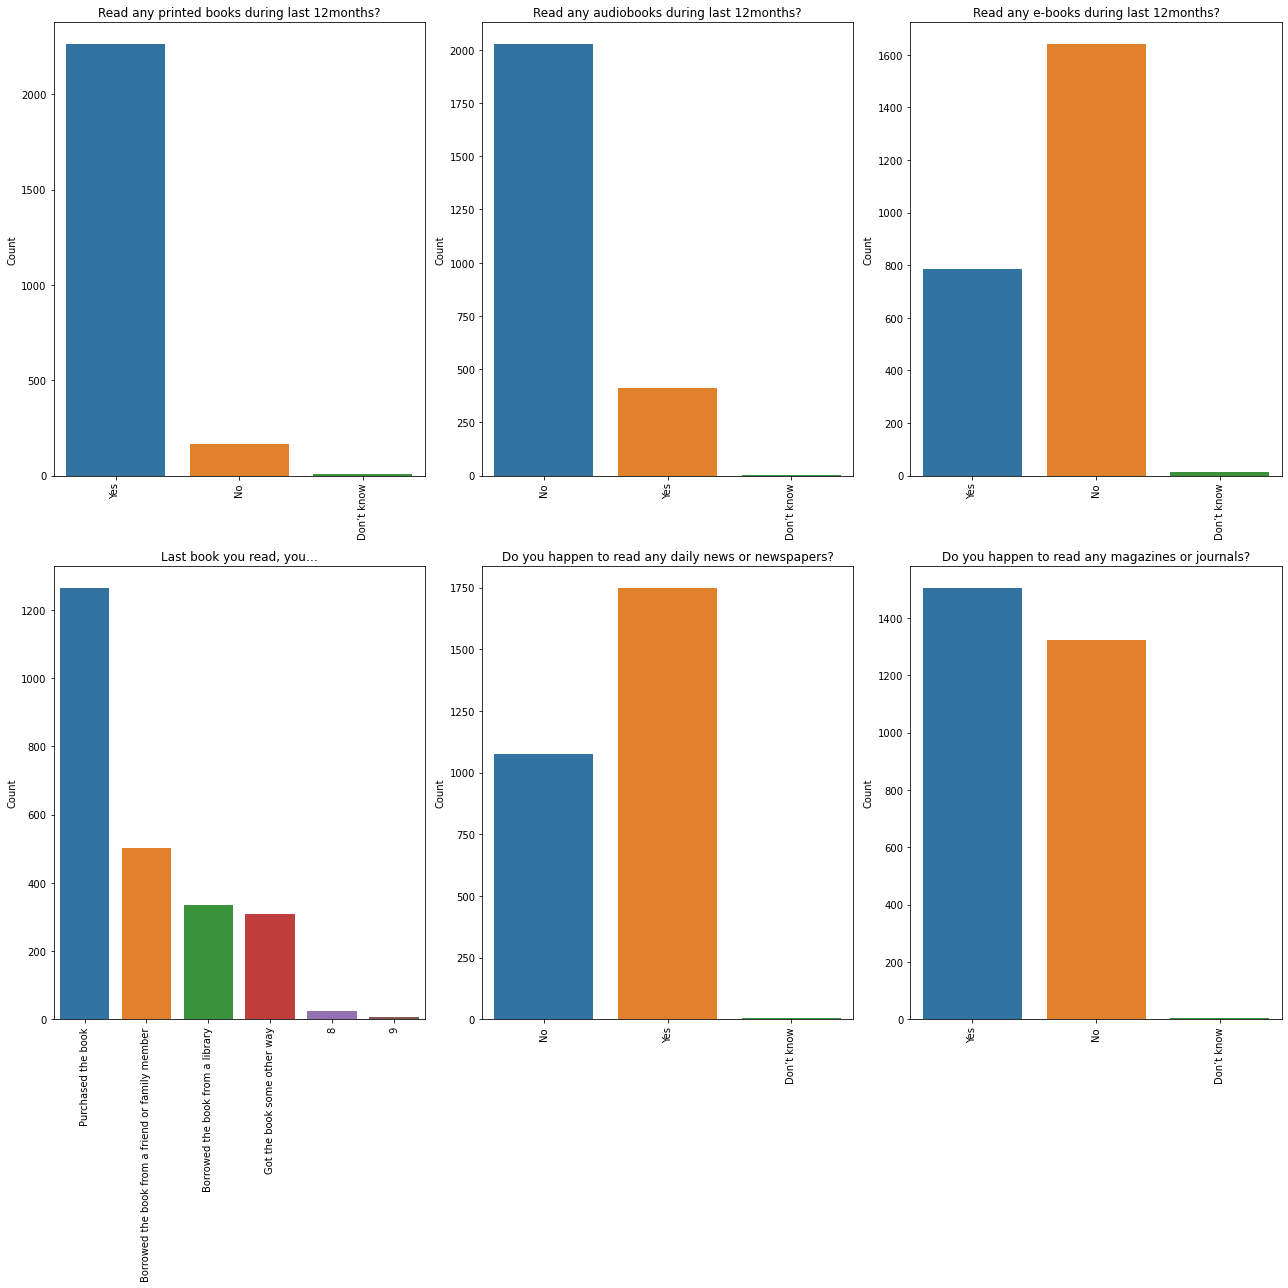

In [67]:
cols = list(data.columns)
# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 18))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each question's count plot
for i, col in enumerate(cols[8:14]):
    sns.countplot(x=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('Count')  # Set y-axis label
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

These look like some good predictive variables, and I'd be interested to see how they interact. A few 'Don't Know' responses; also, for 'Last book you read, you...', '8' and '9' are given as responses. This is weird...

After examining the data, we can now develop a strategy for cleaning it up.

<h2>Cleaning the dataset</h2>

<h4>Strategy for cleaning:</h4>
<li>Rename columns: Some of the column names are long, and this makes them a little unwieldy</li>
<li>Remove readers under 18: Given the issues with how age has been recorded, and my interest in adult readers, it seems safer to remove under 18s</li>
<li>Clean up categorical variables and prep for encoding: Shorten the responses to prepare them for one-hot encoding, and encode binary variables</li>
<li>Code null as 0: As questions about where books came from were understandably not presented to non-readers, these can be coded as 0</li>
<li>Remove 'Refused' and 'Don't Know' responses, as well as sundry invalid responses</li>

In [77]:
### create a pipeline for ingesting and cleaning the data using Prefect

@task
def get_data(input_file):
    ### get the data
    return pd.read_csv(input_file)

@task
def rename_cols(data):
    ### rename columns
    cols = {'Age':'age',
     'Sex':'sex',
     'Race':'race',
     'Marital status?':'marital_status',
     'Education':'education',
     'Employement':'employment',
     'Incomes':'income',
     'How many books did you read during last 12months?':'books_read',
     'Read any printed books during last 12months?':'printed_books_read',
     'Read any audiobooks during last 12months?':'audiobooks_read',
     'Read any e-books during last 12months?':'ebooks_read',
     'Last book you read, you…':'last_book',
     'Do you happen to read any daily news or newspapers?':'read_news',
     'Do you happen to read any magazines or journals?':'read_mags'}

    return data.rename(columns = cols)

@task
def remove_young(data):
    ### remove younger readers
    return data[data['age'] >= 18].copy()

@task
def replace_null(data):
    ### code null values across questions as 0
    return data.fillna(0)

@task
def tidy_race(data):
    ### tidy race

    races = {'Don’t know':np.NaN,
     'Black or African-American':'Black',
     'Mixed race':'Mixed',
     'Other':'Other',
     'Asian or Pacific Islander':'Asian/Pacific',
     'Refused':np.NaN,
     'White':'White',
     'Native American/American Indian':'Native American'}
    
    data['race'] = data['race'].replace(races)

    return data

@task
def tidy_marry(data):
    ### tidy marital status

    marriage = {'Don’t know':np.NaN,
     'Single':'Single',
     'Divorced':'Divorced',
     'Never been married':'Never married',
     'Widowed':'Widowed',
     'Married':'Married',
     'Living with a partner':'Cohabiting',
     'Separated':'Separated'}
    
    data['marital_status'] = data['marital_status'].replace(marriage)

    return data

@task
def tidy_education(data):
    ### tidy education

    education = {'Don’t know':np.NaN,
     'Technical, trade or vocational school AFTER high school':'Technical',
     'Some college, no 4-year degree':'Some college',
     'None':'None',
     'High school incomplete':'Some high school',
     'Post-graduate training/professional school after college':'Postgraduate',
     'College graduate':'Undergraduate',
     'High school graduate':'High school'}
    
    data['education'] = data['education'].replace(education)

    return data

@task
def tidy_employ(data):
    ### tidy employment

    employ = {'Have own business/self-employed':'Self-employed',
     'Employed part-time':'Part-time',
     'Retired':'Retired',
     'Other':'Other',
     'Not employed for pay':'Unemployed',
     'Employed full-time':'Full-time',
     'Student':'Student',
     'Disabled':'Disabled'}
    
    data['employment'] = data['employment'].replace(employ)

    return data

@task
def tidy_income(data):
    ### tidy income

    income = {'$100,000 to under $150,000':'100k to <150k',
     '$75,000 to under $100,000':'75k to <100k',
     '$10,000 to under $20,000':'10k to <20k',
     '$20,000 to under $30,000':'20k to <30k',
     '$30,000 to under $40,000':'30k to <40k',
     'Less than $10,000':'<10k',
     'Refused':np.NaN,
     '9$100,000 to under $150,000':'100k to <150k',
     '$50,000 to under $75,000':'50k to <75k',
     '$40,000 to under $50,000':'40k to <50k'}
    
    data['income'] = data['income'].replace(income)

    return data

@task
def tidy_lastbook(data):
    ### tidy last book read

    last_book = {'Got the book some other way':'Other',
     'Borrowed the book from a friend or family member':'Friend or family',
     '8':np.NaN,
     '9':np.NaN,
     'Borrowed the book from a library':'Library',
     'Purchased the book':'Purchased'}
    
    data['last_book'] = data['last_book'].replace(last_book)

    return data

@task
def tidy_other(data):
    ### tidy other categoricals

    cols = ['printed_books_read',
     'audiobooks_read',
     'ebooks_read',
     'read_news',
     'read_mags']

    for col in cols:
        data[col].replace({"Yes":1,"No":0,"Don’t know":np.NaN}, inplace=True)
    
    return data

@task
def remove_null(data):
    ## remove null values and code floats as int

    data = data.dropna()
    
    cols = ['printed_books_read',
     'audiobooks_read',
     'ebooks_read',
     'read_news',
     'read_mags']

    for col in cols:
        data[col] = data[col].astype(int)
    
    return data

@task
def code_sex(data):
    ### code sex
    data['sex'] = data['sex'].replace({'Female': 0, 'Male': 1})
    return data

@task
def code_dummies(data):
    ## get dummies for remaining categoricals

    cols = []

    for col in list(data.columns):
        if data[col].dtype == 'object':
            cols.append(col)

    return pd.get_dummies(data=data, columns=cols, prefix_sep=': ')

@flow
def data_cleaning_flow(input_file):
    
    data = get_data(input_file)
    
    # clean the data
    data = rename_cols(data)
    data = remove_young(data)
    data = replace_null(data)
    data = tidy_race(data)
    data = tidy_marry(data)
    data = tidy_education(data)
    data = tidy_employ(data)
    data = tidy_income(data)
    data = tidy_lastbook(data)
    data = tidy_other(data)
    
    # remove null values and get dummies
    data = remove_null(data)
    data = code_sex(data)
    data = code_dummies(data)
    
    # get rid of an extra column we don't need
    data = data.drop('last_book: 0', axis=1)
    
    return data

In [78]:
### action the pipeline

if __name__ == "__main__":
    data = data_cleaning_flow('reading.csv')
    print("Data cleaning completed!")
    
data.info()

09:23:34.015 | INFO    | prefect.engine - Created flow run 'brave-spaniel' for flow 'data-cleaning-flow'

09:23:34.085 | INFO    | Flow run 'brave-spaniel' - Created task run 'get_data-0' for task 'get_data'

09:23:34.087 | INFO    | Flow run 'brave-spaniel' - Executing 'get_data-0' immediately...

09:23:34.173 | INFO    | Task run 'get_data-0' - Finished in state Completed()

09:23:34.198 | INFO    | Flow run 'brave-spaniel' - Created task run 'rename_cols-0' for task 'rename_cols'

09:23:34.200 | INFO    | Flow run 'brave-spaniel' - Executing 'rename_cols-0' immediately...

09:23:34.269 | INFO    | Task run 'rename_cols-0' - Finished in state Completed()

09:23:34.293 | INFO    | Flow run 'brave-spaniel' - Created task run 'remove_young-0' for task 'remove_young'

09:23:34.294 | INFO    | Flow run 'brave-spaniel' - Executing 'remove_young-0' immediately...

09:23:34.363 | INFO    | Task run 'remove_young-0' - Finished in state Completed()

09:23:34.387 | INFO    | Flow run 'brave-spaniel' - Created task run 'replace_null-0' for task 'replace_null'

09:23:34.389 | INFO    | Flow run 'brave-spaniel' - Executing 'replace_null-0' immediately...

09:23:34.465 | INFO    | Task run 'replace_null-0' - Finished in state Completed()

09:23:34.488 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_race-0' for task 'tidy_race'

09:23:34.490 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_race-0' immediately...

09:23:34.558 | INFO    | Task run 'tidy_race-0' - Finished in state Completed()

09:23:34.582 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_marry-0' for task 'tidy_marry'

09:23:34.583 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_marry-0' immediately...

09:23:34.653 | INFO    | Task run 'tidy_marry-0' - Finished in state Completed()

09:23:34.676 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_education-0' for task 'tidy_education'

09:23:34.678 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_education-0' immediately...

09:23:34.745 | INFO    | Task run 'tidy_education-0' - Finished in state Completed()

09:23:34.768 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_employ-0' for task 'tidy_employ'

09:23:34.770 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_employ-0' immediately...

09:23:34.837 | INFO    | Task run 'tidy_employ-0' - Finished in state Completed()

09:23:34.860 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_income-0' for task 'tidy_income'

09:23:34.862 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_income-0' immediately...

09:23:34.934 | INFO    | Task run 'tidy_income-0' - Finished in state Completed()

09:23:34.960 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_lastbook-0' for task 'tidy_lastbook'

09:23:34.962 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_lastbook-0' immediately...

09:23:35.041 | INFO    | Task run 'tidy_lastbook-0' - Finished in state Completed()

09:23:35.074 | INFO    | Flow run 'brave-spaniel' - Created task run 'tidy_other-0' for task 'tidy_other'

09:23:35.075 | INFO    | Flow run 'brave-spaniel' - Executing 'tidy_other-0' immediately...

09:23:35.160 | INFO    | Task run 'tidy_other-0' - Finished in state Completed()

09:23:35.186 | INFO    | Flow run 'brave-spaniel' - Created task run 'remove_null-0' for task 'remove_null'

09:23:35.188 | INFO    | Flow run 'brave-spaniel' - Executing 'remove_null-0' immediately...

/var/folders/d0/1knvbk1d1dscf7ymrd0bmj8c0000gn/T/ipykernel_63393/1736396095.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(int)


09:23:35.335 | INFO    | Task run 'remove_null-0' - Finished in state Completed()

09:23:35.363 | INFO    | Flow run 'brave-spaniel' - Created task run 'code_sex-0' for task 'code_sex'

09:23:35.365 | INFO    | Flow run 'brave-spaniel' - Executing 'code_sex-0' immediately...

/var/folders/d0/1knvbk1d1dscf7ymrd0bmj8c0000gn/T/ipykernel_63393/1736396095.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sex'] = data['sex'].replace({'Female': 0, 'Male': 1})


09:23:35.453 | INFO    | Task run 'code_sex-0' - Finished in state Completed()

09:23:35.481 | INFO    | Flow run 'brave-spaniel' - Created task run 'code_dummies-0' for task 'code_dummies'

09:23:35.484 | INFO    | Flow run 'brave-spaniel' - Executing 'code_dummies-0' immediately...

09:23:35.563 | INFO    | Task run 'code_dummies-0' - Finished in state Completed()

09:23:35.593 | INFO    | Flow run 'brave-spaniel' - Finished in state Completed()

Data cleaning completed!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2827
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            2325 non-null   int64
 1   sex                            2325 non-null   int64
 2   books_read                     2325 non-null   int64
 3   printed_books_read             2325 non-null   int64
 4   audiobooks_read                2325 non-null   int64
 5   ebooks_read                    2325 non-null   int64
 6   read_news                      2325 non-null   int64
 7   read_mags                      2325 non-null   int64
 8   race: Asian/Pacific            2325 non-null   uint8
 9   race: Black                    2325 non-null   uint8
 10  race: Mixed                    2325 non-null   uint8
 11  race: Native American          2325 non-null   uint8
 12  race: Other                    2325 non-null   uint

In [79]:
new_total_rows = len(data)

perc_loss = (total_rows - new_total_rows) / total_rows * 100

print(f"Removing the non-null rows, income = refused, and under 18s, amongst others, has reduced the dataset length by {round(perc_loss,1)}%")

Removing the non-null rows, income = refused, and under 18s, amongst others, has reduced the dataset length by 17.9%


Now we have a clean dataset with 2325 values. We began with 2832, which means we've removed 17.9% of the original values. Mostly this was because of the under 18s and the people who refused to answer their income questions. However, 2325 is still a good number of values. Let's look at some of the distributions we looked at before to see how this has affected the data:

Sex
0    51.87
1    48.13
Name: sex, dtype: float64

Race
race: Asian/Pacific: 2.45%
race: Black: 12.73%
race: Mixed: 2.15%
race: Native American: 1.08%
race: Other: 1.98%
race: White: 79.61%

Income
income: 100k to <150k: 27.96%
income: 10k to <20k: 8.65%
income: 20k to <30k: 9.55%
income: 30k to <40k: 10.62%
income: 40k to <50k: 8.22%
income: 50k to <75k: 15.78%
income: 75k to <100k: 12.82%
income: <10k: 6.41%


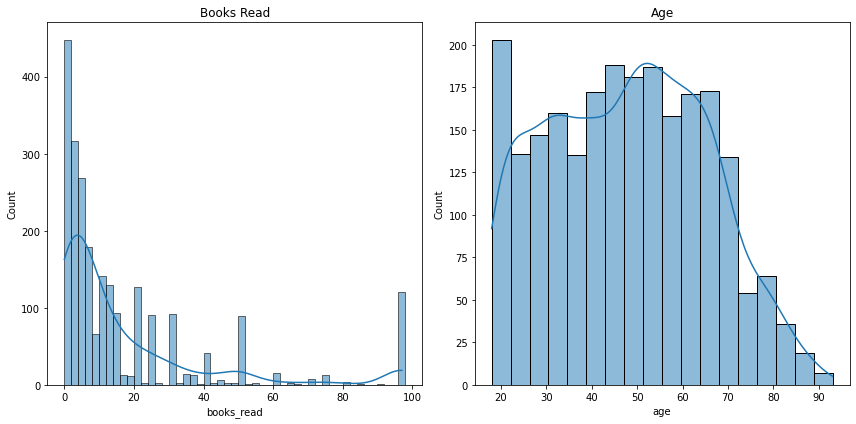

In [80]:
print('Sex')
category_counts = data['sex'].value_counts()
category_percentages = category_counts / len(data) * 100
print(f"{round(category_percentages,2)}")

print('\nRace')
races = ['race: Asian/Pacific',
       'race: Black', 'race: Mixed', 'race: Native American', 'race: Other',
       'race: White']
for race in races:
    races_count = data[['race: Asian/Pacific',
       'race: Black', 'race: Mixed', 'race: Native American', 'race: Other',
       'race: White']].sum().sum()
    print(f"{race}: {round(data[race].sum()/races_count*100, 2)}%")

print('\nIncome')
incomes = ['income: 100k to <150k', 'income: 10k to <20k', 'income: 20k to <30k',
       'income: 30k to <40k', 'income: 40k to <50k', 'income: 50k to <75k',
       'income: 75k to <100k', 'income: <10k']
for income in incomes:
    incomes_count = data[['income: 100k to <150k', 'income: 10k to <20k', 'income: 20k to <30k',
       'income: 30k to <40k', 'income: 40k to <50k', 'income: 50k to <75k',
       'income: 75k to <100k', 'income: <10k']].sum().sum()
    print(f"{income}: {round(data[income].sum()/incomes_count*100, 2)}%")
    
# lets look again at two plots of books read and age side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data['books_read'], kde=True, ax=axes[0], binwidth=2)
axes[0].set_title('Books Read')

sns.histplot(data['age'], kde=True, ax=axes[1])
axes[1].set_title('Age')

plt.tight_layout()
plt.show()

In [81]:
data.describe()

,age,sex,books_read,printed_books_read,audiobooks_read,ebooks_read,read_news,read_mags,race: Asian/Pacific,race: Black,...,income: 20k to <30k,income: 30k to <40k,income: 40k to <50k,income: 50k to <75k,income: 75k to <100k,income: <10k,last_book: Friend or family,last_book: Library,last_book: Other,last_book: Purchased
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,47.602151,0.481290,16.795269,0.796129,0.144946,0.292473,0.623226,0.531613,0.024516,0.127312,...,0.095484,0.106237,0.082151,0.157849,0.128172,0.064086,0.181075,0.104086,0.107527,0.462796
std,17.496336,0.499757,23.943175,0.402961,0.352122,0.454996,0.484682,0.499107,0.154678,0.333394,...,0.293945,0.308206,0.274653,0.364678,0.334353,0.244959,0.385163,0.305438,0.309849,0.498721
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,20.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,93.000000,1.000000,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It looks like we've lost a few women, who were perhaps less likely to report an income. Otherwise, distributions look fairly similar to before.

The age distribution still skews a little younger.

So, now we have a tidy, if not unproblematic, dataset, that we can use to draw some inferences about the population we're studying (and draw some firmly caveated conclusions about reading habits amongst readers in 2011 United States!).

<h2>Exploratory Data Analysis</h2>

We begin by looking at some correlation matrices to examine possible interactions between the variables. We can then look at anything interesting in more detail with some graphs.

<h4>Strategy</h4>
<li>Correlation matrix - see what interactions I might have</li>
<li>Scatterplots and boxplots for interesting looking univariate relationships</li>

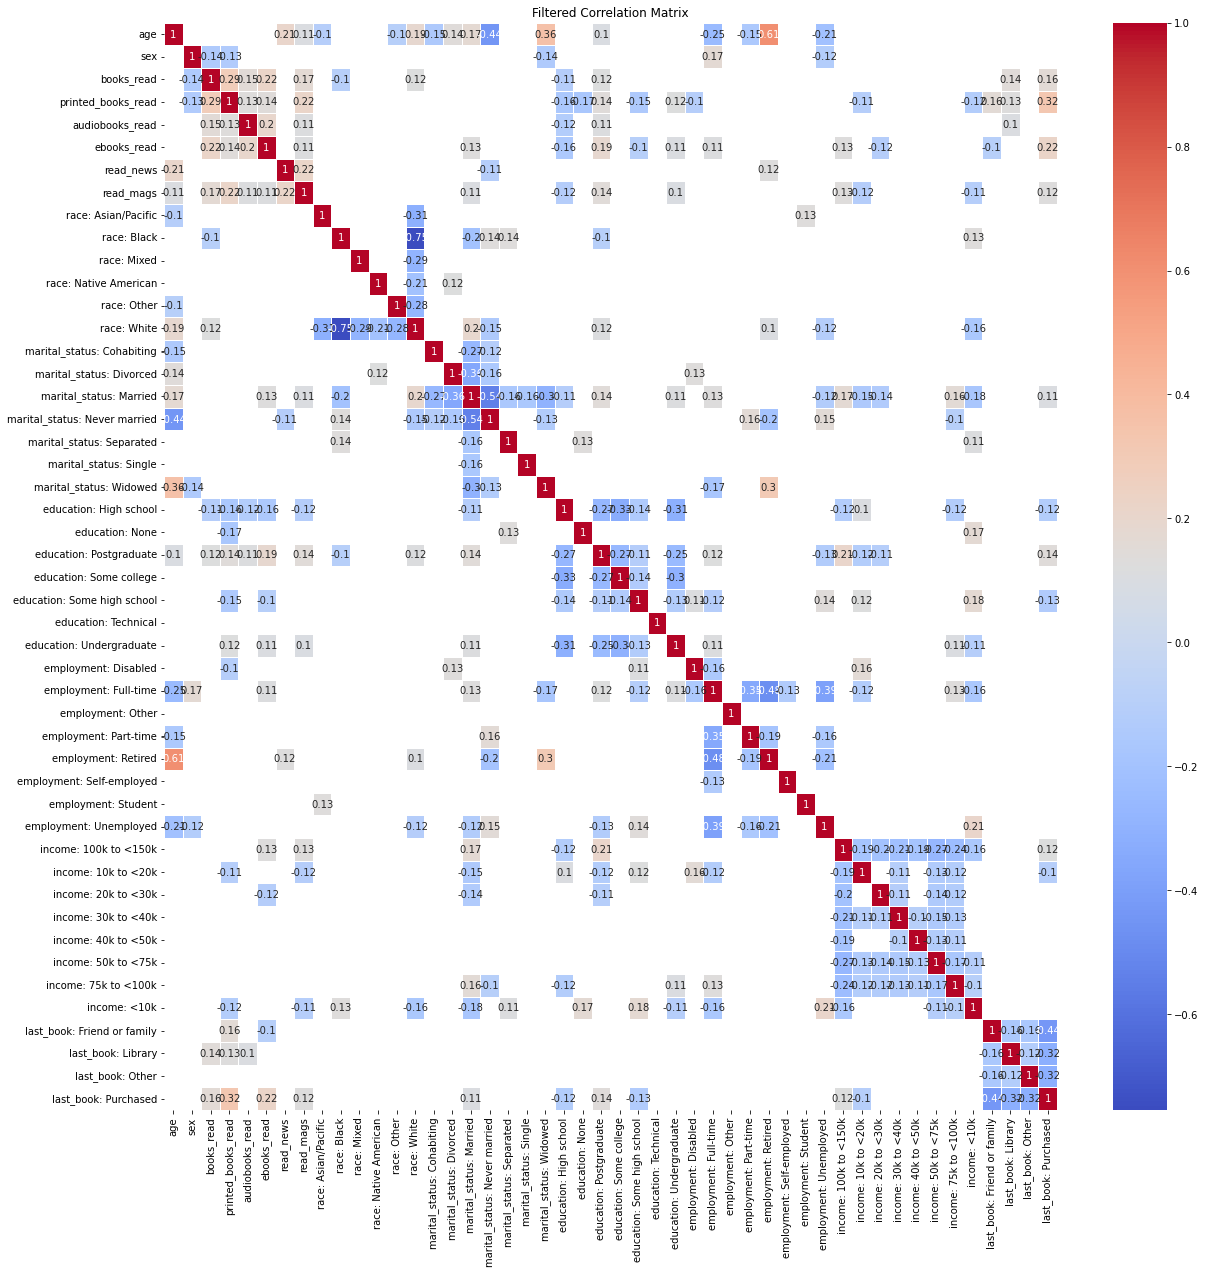

In [82]:
### correlation matrix

corr_matrix = data.corr()

# filter correlations greater than 0.1 or less than -0.1
filtered_corr_matrix = corr_matrix[(corr_matrix > 0.1) | (corr_matrix < -0.1)]

plt.figure(figsize=(20, 20))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=filtered_corr_matrix.isnull())
plt.title('Filtered Correlation Matrix')
plt.show()

Some interactions are unsurprising; the one-hot encoded variables, are, of course, negatively correlated. There are some unsurprising demographic findings--Retired people tend to be older and widowed; people with an income under $10,000 are more likely to be less educated or unemployed; younger people tend to have never married.

The White people in the dataset also seem to tend to be older--this might be a bias in the data collection.

Let's dig a little deeper and have a look at how these interact with number of books read.

Text(0.5, 1.0, 'Books read vs Age')

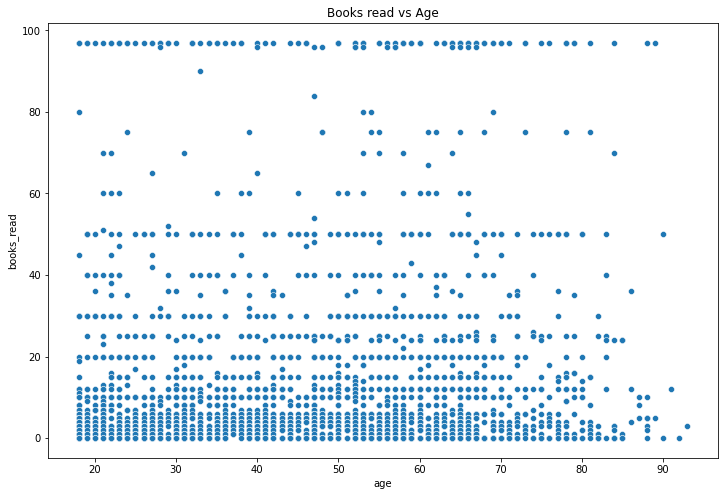

In [83]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='books_read', data=data)
plt.title(f'Books read vs Age')

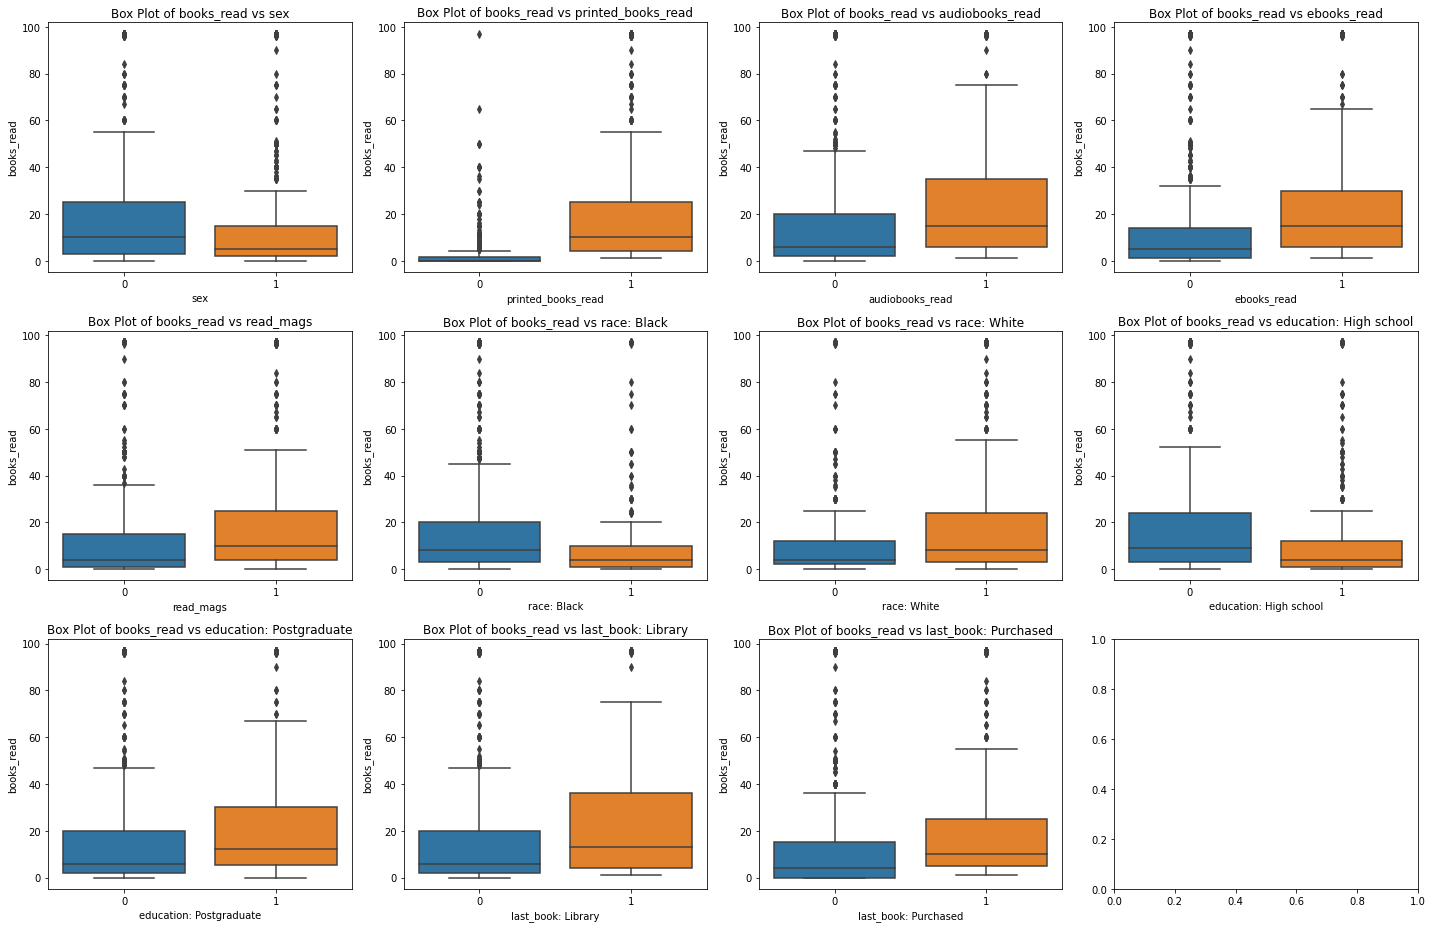

In [93]:
### looking at some scatterplots and boxplots

# filter correlations for books read
filtered_corrs = corr_matrix['books_read'][(corr_matrix['books_read'] > 0.1) | (corr_matrix['books_read'] < -0.1)]
filtered_columns = filtered_corrs.index.tolist()
filtered_columns.remove('books_read')

fig, axes = plt.subplots(3, 4, figsize=(20, 13))
axes = axes.flatten()

for i, var in enumerate(filtered_columns):
    sns.boxplot(ax=axes[i], x=var, y='books_read', data=data)
    axes[i].set_title(f'Box Plot of books_read vs {var}')

plt.tight_layout()
plt.show()

Some interesting potential predictive variables here: Age and books read don't seem to be correlated. Men look less likely to read than women; people who read printed books, audiobooks, ebooks and magazines all seem more likely to read in general (unsurprising, as people who read 0 books in the last year would be 0 for these questions too--these variables may better help us distinguish between different types of readers, rather than readers and non-readers; in future analysis, we might remove non-readers completely). Black people seem less likely to read, and White people more likely, which would be an important finding for staging interventions based on this data. People whose highest level of education is high school are less likely to read, and people whose highest is postgraduate are more likely to read; and people who buy books and use libraries may be more likely to read.

Let's have a look at other interesting interactions between the variables.

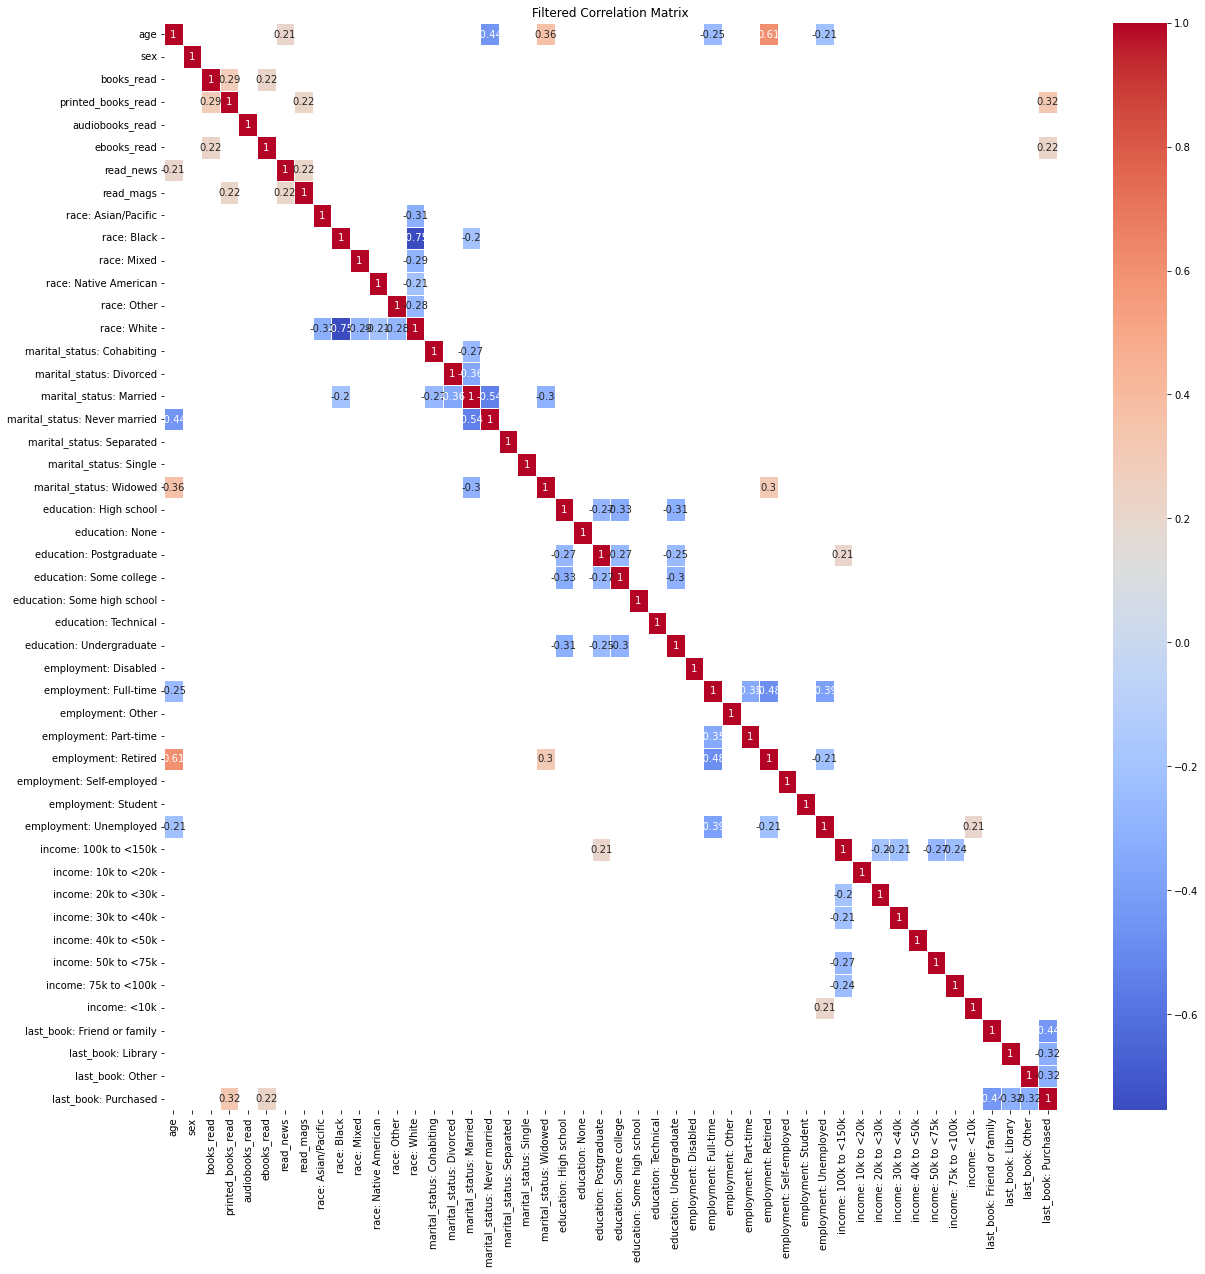

In [94]:
### other interesting interactions - let's raise the threshold

corr_matrix = data.corr()

# filter correlations greater than 0.2 or less than -0.2
filtered_corr_matrix = corr_matrix[(corr_matrix > 0.2) | (corr_matrix < -0.2)]

plt.figure(figsize=(20, 20))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=filtered_corr_matrix.isnull())
plt.title('Filtered Correlation Matrix')
plt.show()

There are some interesting interactions here--people who bought their last book are more likely to read print books and ebooks.

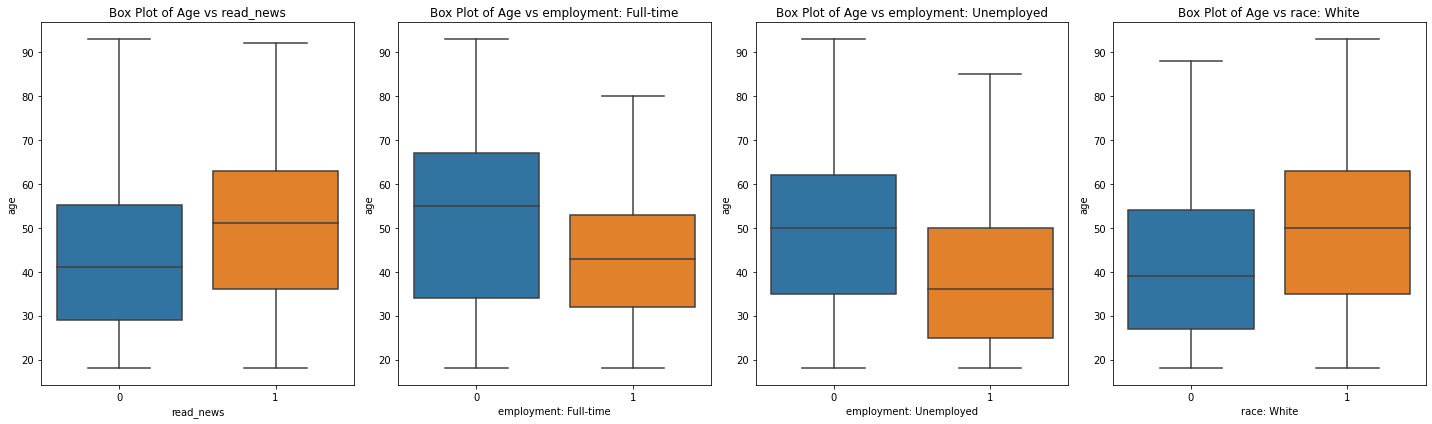

In [95]:
### plotting variables against age

cols = ['read_news','employment: Full-time','employment: Unemployed','race: White']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(ax=axes[i], x=col, y='age', data=data)
    axes[i].set_title(f'Box Plot of Age vs {col}')

plt.tight_layout()
plt.show()

It looks like older people tend to read the news more, and tend to be White, while younger people tend to either work full-time or be unemployed.

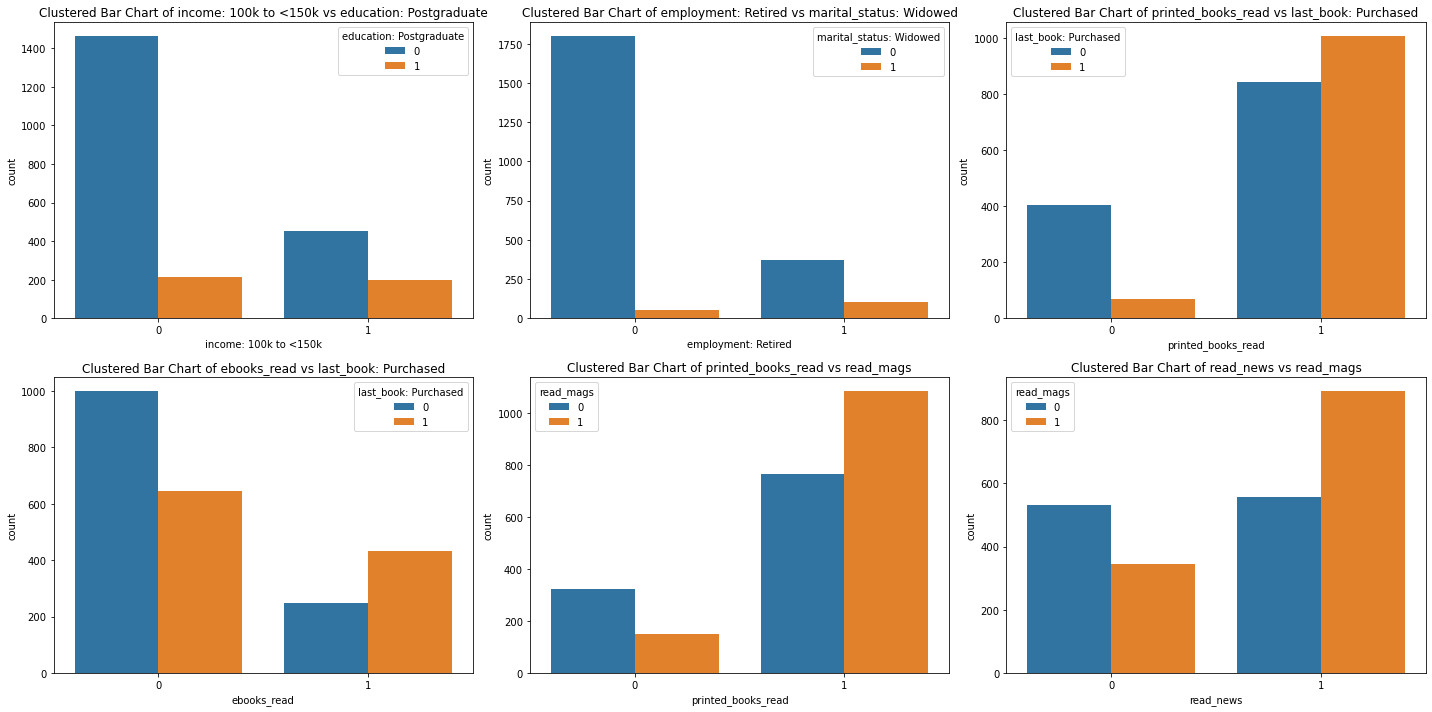

In [99]:
### let's look at some other interactions

pairs = [('income: 100k to <150k', 'education: Postgraduate'),
    ('employment: Retired', 'marital_status: Widowed'),
    ('printed_books_read', 'last_book: Purchased'),
    ('ebooks_read', 'last_book: Purchased'),
    ('printed_books_read', 'read_mags'),
    ('read_news','read_mags')]


fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, pair in enumerate(pairs):
    
    contingency_table = pd.crosstab(data[pair[0]], data[pair[1]])
    contingency_table = contingency_table.reset_index()
    melted_df = contingency_table.melt(id_vars=pair[0], var_name=pair[1], value_name='count')
    
    sns.barplot(x=pair[0], y='count', hue=pair[1], data=melted_df, ax=axes[i])
    axes[i].set_title(f'Clustered Bar Chart of {pair[0]} vs {pair[1]}')

plt.tight_layout()
plt.show()

Some key insights into the dataset here: People with postgraduate degress tend to have higher incomes; widowed people are more likely to be retired; people who read printed books are more like to have bought their last book, and same for eBooks; people who read printed books are also more likely to read magazines, too; and people who read magazines are more likely to read the news. 

So, at present we have a good idea of some key predictors for books read, and we have a bit more of an understanding about the biases and other correlations in the data that might speak to the method of collection and/or the cleaning process and rows removed.

Let's look now at a linear regression model and see what variables look like they'll be good predictors.

<h3>Linear Regression Model</h3>

In [100]:
### take an initial look at a linear regression model

y = data['books_read']
X = data.drop(['books_read'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             books_read   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     12.03
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           9.00e-72
Time:                        09:47:36   Log-Likelihood:                -10450.
No. Observations:                2325   AIC:                         2.099e+04
Df Residuals:                    2282   BIC:                         2.123e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

We can see some strong predictors in there, which is encouraging for building a predictive analytics model. There's also a lot of weak predictors. Let's refine this a little.

In [103]:
## start to refine the model by removing high p value

y = data['books_read']
X = data.drop(['books_read'], axis=1)
X = sm.add_constant(X)

def backward_elimination(X, y, threshold=0.05):
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > threshold:
            worst_feature = p_values.idxmax()
            X = X.drop(columns=[worst_feature])
        else:
            break
    return model

final_model = backward_elimination(X, y)
ols_p_cols = list(dict(final_model.params))

y = data['books_read']
X = data[ols_p_cols]
X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             books_read   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     43.26
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           4.51e-86
Time:                        09:48:54   Log-Likelihood:                -10465.
No. Observations:                2325   AIC:                         2.095e+04
Df Residuals:                    2313   BIC:                         2.102e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

This process of iterating through and removing features with high p values has left us with 11 variables that we can hypothesise are important. At this stage, we can see that being a woman, reading print books, audiobooks, ebooks, and magazines, being Native American or White, and getting your book from the library or buying it are good predictors of reading more books; being a man and working full-time or being unemployed are predictors of reading less.

This is interesting to know; we could stop here. However, let's take it further, and have a look at selecting and optimising a predictive model.

<h2>Model Selection</h2>

Here, we test a few linear models and some non-linear/ensemble models, evaluating them using the common metrics of MSE, RMSE, MAE, and r2.

<h4>Test the following models:</h4>
<li>Linear regression</li>
<li>Lasso regression</li>
<li>Ridge regression</li>
<li>Decision tree regression</li>
<li>Random forest regression</li>
<li>Gradient boosting regression</li>
<h4>Evaluation metrics:</h4>
<li>Mean Square Error</li>
<li>Root Mean Square Error</li>
<li>Mean Absolute Error</li>
<li>R2</li>

In [117]:
def test_models(y, X):

    # prepare data and split into test train

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    alpha = 1.0
    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])

    # define models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': ridge_pipeline,
        'Lasso': Lasso(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boost': GradientBoostingRegressor()
    }

    results = []

    # evaluate models using cross-validation
    for name, model in models.items():
        scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        scores_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

        mse = -scores_mse  # convert to positive MSE
        rmse = np.sqrt(mse)
        mae = -scores_mae  # convert to positive MAE

        results.append({
            'Model': name,
            'Mean MSE': mse.mean(),
            'Std Dev MSE': mse.std(),
            'Mean RMSE': rmse.mean(),
            'Std Dev RMSE': rmse.std(),
            'Mean MAE': mae.mean(),
            'Std Dev MAE': mae.std(),
            'Mean R2': scores_r2.mean(),
            'Std Dev R2': scores_r2.std()
        })

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Display the results DataFrame
    print(results_df)

In [118]:
y = data['books_read']
X = data.drop(['books_read'], axis=1)

test_models(y, X)

               Model    Mean MSE  Std Dev MSE  Mean RMSE  Std Dev RMSE  \
0  Linear Regression  495.908412   114.603709  22.138901      2.403640   
1              Ridge  495.893254   114.630305  22.138498      2.404196   
2              Lasso  520.676941   133.181693  22.656366      2.714039   
3      Decision Tree  975.950941   103.211809  31.196283      1.656156   
4      Random Forest  539.739528    93.621804  23.151737      1.933029   
5     Gradient Boost  509.630947   122.304717  22.431162      2.544392   

    Mean MAE  Std Dev MAE   Mean R2  Std Dev R2  
0  14.956739     1.184449  0.135875    0.021139  
1  14.955296     1.184827  0.135911    0.021134  
2  15.319399     1.396124  0.097094    0.020985  
3  18.560484     1.268199 -0.718764    0.167759  
4  15.316145     1.282924  0.037397    0.068851  
5  14.901051     1.532327  0.111596    0.025018  


Ridge and linear regression tend to perform better, suggesting that this is a linear problem. However, as we have thrown all the features in, the R2 is probably lower than we would expect.

The decision tree model has the worst results and worst stability.

Let's try with fewer features--using the features identified in Linear Regression model from the EDA stage would be a good start.

In [119]:
y = data['books_read']
X = data[ols_p_cols] ## use the columns from the Statsmodels.OLS model just to see if this improves Linear Regression

test_models(y, X)

               Model    Mean MSE  Std Dev MSE  Mean RMSE  Std Dev RMSE  \
0  Linear Regression  491.854920   117.116712  22.040782      2.461477   
1              Ridge  491.850231   117.134094  22.040636      2.461830   
2              Lasso  523.415619   134.329313  22.714934      2.728995   
3      Decision Tree  596.480801   144.862637  24.262338      2.796386   
4      Random Forest  559.632340   131.778024  23.512125      2.610046   
5     Gradient Boost  494.371805   110.272225  22.112843      2.322495   

    Mean MAE  Std Dev MAE   Mean R2  Std Dev R2  
0  14.784813     1.261342  0.144028    0.020832  
1  14.784097     1.261589  0.144042    0.020831  
2  15.394622     1.417189  0.092462    0.021919  
3  15.425385     1.663876 -0.040818    0.088385  
4  15.203815     1.622275  0.021660    0.060678  
5  14.480095     1.275027  0.137391    0.009457  


Again, Ridge tends to perform marginally better than the linear model. Gradient Boost also outperforms on the MAE score. Moving forward with Ridge and using its regularisation to remove variables would be a good approach going forward.

In [120]:
# prepare data and split into test train

y = data['books_read']
X = data.drop(['books_read'], axis=1)  # using all features and regularisation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features to improve the performance of Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# use cross_val_score with the scaled data
scores_mse = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
scores_mae = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='r2')

mse = -scores_mse  # convert to positive MSE
rmse = np.sqrt(mse)
mae = -scores_mae  # convert to positive MAE

print('Cross validation:')
print(f'Ridge: Mean MSE = {mse.mean():.4f}, Std Dev MSE = {mse.std():.4f}')
print(f'Ridge: Mean RMSE = {rmse.mean():.4f}, Std Dev RMSE = {rmse.std():.4f}')
print(f'Ridge: Mean MAE = {mae.mean():.4f}, Std Dev MAE = {mae.std():.4f}')
print(f'Ridge: Mean R2 = {scores_r2.mean():.4f}, Std Dev R2 = {scores_r2.std():.4f}')
print('\n')

# fit Ridge model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# test it against the test data
y_pred = ridge.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test set vs prediction scores:')
print(f'Ridge: MSE = {mse:.4f}')
print(f'Ridge: RMSE = {rmse:.4f}')
print(f'Ridge: MAE = {mae:.4f}')
print(f'Ridge: R2 = {r2:.4f}')
print('\n')

# get feature names and coefficients and sort
feature_names = X.columns
coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

# print top features, printing as many features as we identified with the linear model for simplicity
for feature, coef in feature_importance[:len(ols_p_cols)]:  
    print(f"{feature}: {coef}")

Cross validation:
Ridge: Mean MSE = 495.8931, Std Dev MSE = 114.6306
Ridge: Mean RMSE = 22.1385, Std Dev RMSE = 2.4042
Ridge: Mean MAE = 14.9553, Std Dev MAE = 1.1848
Ridge: Mean R2 = 0.1359, Std Dev R2 = 0.0211


Test set vs prediction scores:
Ridge: MSE = 468.3075
Ridge: RMSE = 21.6404
Ridge: MAE = 14.7894
Ridge: R2 = 0.1438


ebooks_read: 3.7133830997512485
last_book: Purchased: 3.6371437870285157
last_book: Library: 3.5756346905473104
printed_books_read: 3.3869023179773996
sex: -2.4622524840531392
read_mags: 1.592382561759842
employment: Retired: 1.4931322361347483
audiobooks_read: 1.4099315323301427
last_book: Other: 1.2421762136381702
employment: Other: 1.1270104273420904
employment: Full-time: -1.0254601940920909


Let's compare these top features to those from the OLS model

In [121]:
ridge_features = feature_importance[:len(ols_p_cols)]
ridge_feature_names = []

for feat, coef in ridge_features:
    ridge_feature_names.append(feat)

for feature in ridge_feature_names:
    if feature in ols_p_cols:
        print(f"{feature} is common in both")
    else:
        print(f"{feature} is only in Ridge")

for feature in ols_p_cols:
    if feature not in ridge_feature_names:
        print(f"{feature} is only in OLS")

ebooks_read is common in both
last_book: Purchased is common in both
last_book: Library is common in both
printed_books_read is common in both
sex is common in both
read_mags is common in both
employment: Retired is only in Ridge
audiobooks_read is common in both
last_book: Other is only in Ridge
employment: Other is only in Ridge
employment: Full-time is common in both
race: Native American is only in OLS
race: White is only in OLS
employment: Unemployed is only in OLS


The presence of some common features is encouraging, and suggests that these are more robust predictors. However, there are some differences. What would happen if we combined the 11 variables from OLS and the top 11 from Ridge?

In [122]:
# combine the features this time

ridge_ols = list(set(ridge_feature_names + ols_p_cols))

y = data['books_read']
X = data[ridge_ols]

test_models(y, X)

               Model    Mean MSE  Std Dev MSE  Mean RMSE  Std Dev RMSE  \
0  Linear Regression  492.332719   114.235820  22.058259      2.401238   
1              Ridge  492.323702   114.250666  22.058020      2.401553   
2              Lasso  523.289893   134.402449  22.711953      2.730764   
3      Decision Tree  658.994677   150.510623  25.521082      2.769304   
4      Random Forest  583.785105   146.121218  23.994158      2.839980   
5     Gradient Boost  491.541142   103.299572  22.062472      2.188257   

    Mean MAE  Std Dev MAE   Mean R2  Std Dev R2  
0  14.800064     1.235752  0.142143    0.022750  
1  14.799254     1.235978  0.142165    0.022739  
2  15.392080     1.418937  0.092715    0.022056  
3  15.859763     1.655947 -0.143906    0.066305  
4  15.304744     1.713218 -0.019078    0.078179  
5  14.406038     1.198167  0.140269    0.025219  


Both Linear and Ridge are poorer here--Gradient Boost performs very well, though, although the R2 is lower. There is also a risk of overfitting with this method, and the performance is not noticeably higher. I'd be tempted to avoid it, though we could look into optimising it in future analysis. So, while we can fiddle around a bit more with the number of features, this feels like a good place to stop for now. Let's operationalise our final model: Ridge Regression, using top features identified with the OLS methods.

In [123]:
# prepare data and split into test train

y = data['books_read']
X = data[ols_p_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features to improve the performance of Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# use cross_val_score with the scaled data
scores_mse = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
scores_mae = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_r2 = cross_val_score(Ridge(alpha=1), X_train_scaled, y_train, cv=5, scoring='r2')

mse = -scores_mse  # convert to positive MSE
rmse = np.sqrt(mse)
mae = -scores_mae  # convert to positive MAE

print('Cross validation:')
print(f'Ridge: Mean MSE = {mse.mean():.4f}, Std Dev MSE = {mse.std():.4f}')
print(f'Ridge: Mean RMSE = {rmse.mean():.4f}, Std Dev RMSE = {rmse.std():.4f}')
print(f'Ridge: Mean MAE = {mae.mean():.4f}, Std Dev MAE = {mae.std():.4f}')
print(f'Ridge: Mean R2 = {scores_r2.mean():.4f}, Std Dev R2 = {scores_r2.std():.4f}')
print('\n')

# fit Ridge model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# test it against the test data
y_pred = ridge.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test set vs prediction scores:')
print(f'Ridge: MSE = {mse:.4f}')
print(f'Ridge: RMSE = {rmse:.4f}')
print(f'Ridge: MAE = {mae:.4f}')
print(f'Ridge: R2 = {r2:.4f}')
print('\n')

# get feature names and coefficients and sort
feature_names = X.columns
coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

# print top features, printing as many features as we identified with the linear model for simplicity
for feature, coef in feature_importance[:len(ols_p_cols)]:  
    print(f"{feature}: {coef}")

Cross validation:
Ridge: Mean MSE = 491.8501, Std Dev MSE = 117.1347
Ridge: Mean RMSE = 22.0406, Std Dev RMSE = 2.4618
Ridge: Mean MAE = 14.7841, Std Dev MAE = 1.2616
Ridge: Mean R2 = 0.1440, Std Dev R2 = 0.0208


Test set vs prediction scores:
Ridge: MSE = 452.5750
Ridge: RMSE = 21.2738
Ridge: MAE = 14.4306
Ridge: R2 = 0.1726


printed_books_read: 4.136647811211704
ebooks_read: 3.7434391018596926
last_book: Library: 2.9191567732391546
last_book: Purchased: 2.565005790178629
sex: -2.388101098395809
employment: Full-time: -2.2581124650134408
race: White: 1.9000763397546472
read_mags: 1.6201927678785064
audiobooks_read: 1.4666861952180212
race: Native American: 1.3301075046313522
employment: Unemployed: -1.105507066422844


<h2>Final model</h2>

Final Model Performance:
MSE: 475.2529
RMSE: 21.8003
MAE: 14.5665
R2: 0.1706

Feature Importances:
printed_books_read: 1.7087
ebooks_read: 1.6967
sex: -1.0837
last_book: Purchased: 1.0189
employment: Full-time: -0.9739
read_mags: 0.9235
last_book: Library: 0.9145
race: White: 0.8954
audiobooks_read: 0.5764
employment: Unemployed: -0.3499
race: Native American: 0.1047


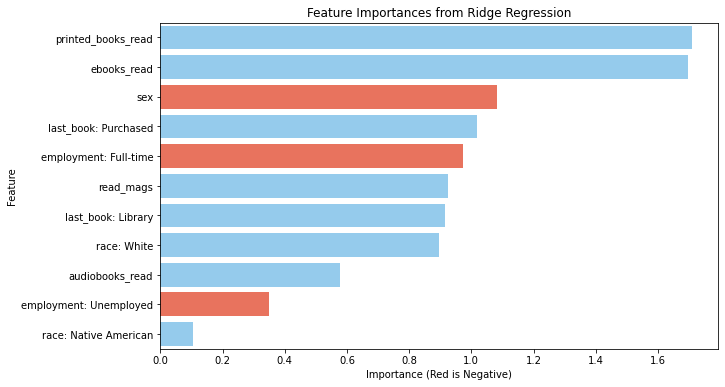

In [125]:
# prepare the data and set up a pipeline
y = data['books_read']
X = data[ols_p_cols]

alpha = 1.0
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=alpha))
])

# fit the model on all data and make predictions
ridge_pipeline.fit(X, y)
y_pred = ridge_pipeline.predict(X)

# calculate performance metrics and print results
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

# extract feature importances and sort
ridge_model = ridge_pipeline.named_steps['ridge']
scaler = ridge_pipeline.named_steps['scaler']
feature_importance = ridge_model.coef_ * scaler.scale_
feature_importance_dict = dict(zip(X.columns, feature_importance))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nFeature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")
    
# graph out the features
feature_importances_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# define colours
feature_importances_df['colors'] = ['lightskyblue' if val > 0 else 'tomato' for val in feature_importances_df['Importance']]
feature_importances_df['Importance'] = np.abs(feature_importances_df['Importance'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette=feature_importances_df['colors'])
plt.title('Feature Importances from Ridge Regression')
plt.xlabel('Importance (Red is Negative)')
plt.ylabel('Feature')
plt.show()

Some tentative conclusions: Our biggest readers look to be white or Native American women who use eBooks, print books, and audiobooks, and bought their last book or got it from the library. They also read magazines. Our lowest readers are men in full-time employment or who are unemployed.

Some caveats: The centred R2 score is still pretty low, which indicates that this model isn't capturing everything. Indeed, the predictions are out by an average of 14 books, which is quite a lot. However, we have identified some issues in the data collection, such as self-reporting

<h2>Discussion and Conclusion</h2>

This notebook has used a survey on reading habits in the United States conducted in 2011 to draw some inferences about key factors that influence the number of books read. We have managed to profile high-volume readers as women who read a combination of eBooks, print books, and audiobooks, as well as magazines, and who use libraries. Our lowest readers tend to be men in full-time employment or out of employment. This information is useful for marketing campaigns and targetting readers most likely to buy books.

There are several limitations to this dataset. Firstly, it does not ask about genre or length of books read, or other significant marketing factors, which limits the useability. For example, high-volume readers may read shorter, less demanding books, while low-volume readers may read longer, more demanding books. Secondly, there are problems with self-reporting: when stating number of books, lots of people rounded to 30, 40, or 50. This speaks to issues of estimating number of books read in 12 months. Indeed, that eBooks are shown to be significant may be because they allow users to more accurately count how many books have been read over a certain period. A significant number of people were also unwilling to declare their income, which limits the analysis.

The cleaning process has removed a significant number of respondents. Because of a seeming lack of specificity, this dataset does not speak to reading habits of younger readers. This was probably due to the nature of data collection, and to find about more about middle grade and young adult readers, a more focused survey (that takes into account specific data protection and ethical considerations) should be conducted. People who refused to answer questions about income were also removed. As it turned out that income was not a strong predictor of books read, we might rerun this analysis without removing these people and see if anything turns out differently.

Finally, we do not know enough about the data collection method to know how representative the sample is of the broader population. Where and how were these people found? What influenced them to take part in the survey? These are important questions to know if we want to take this analysis further.

<h4>Other analysis we could use</h4>
<p>The decision was made to focus on number of books read as a linear regression problem. This is effective, but limited, and has failed to capture every nuance of reading habits and the factors that dictate how many books have been read. The accuracy measures are not as high as we would have liked, which show that other factors are at play. However, we could also use this data to formulate a logistic regression problem--we could categorise readers as non-readers, low, medium or high volume readers, and then begin to identify factors that influence the classification. Alternatively, we could also turn this into a clustering question, and start clustering readers using KNN or similar algorithms. This could then form the basis of a customer segmentation model.</p>

<p>In the EDA, we could also use <i>t</i>-tests as part of the univariate analysis to compare distibrutions within categories.</p>

<p>Finally, we could turn this analysis on its head and use the number of books read as a predictor in itself. Can it can predict income or employment status, for example?</p>